In [1]:
# Import libraries
'''Main'''
import numpy as np # linear algebra
import pandas as pd # data processing

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
import pickle, gzip
from sklearn import preprocessing as pp # impute missing values, normalize data, etc.
from scipy.stats import pearsonr # calculate correlation matrix
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split # generate training and test sets
from sklearn.model_selection import StratifiedKFold # generate validation sets
from sklearn.metrics import log_loss # calculate log-loss (or cross entropy between the true labels and the predictions)
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
import time

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
import lightgbm as lgb

In [2]:
# Load the datasets
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [4]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [5]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [6]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
def view_digit(example):
    label = y_train.loc[0]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

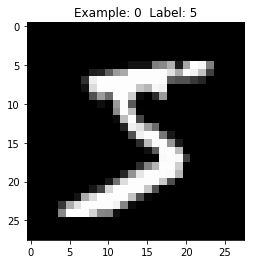

In [8]:
# View the first digit
view_digit(0)

In [9]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [10]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [11]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [12]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [13]:
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [14]:
# Percentage of Variance Captured by n principal components, where n = 784 here
print("Variance Explained by all 784 principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999999999992


In [15]:
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.48876238]
Variance Captured by First 20 Principal Components:  [0.64398025]
Variance Captured by First 50 Principal Components:  [0.8248609]
Variance Captured by First 100 Principal Components:  [0.91465857]
Variance Captured by First 200 Principal Components:  [0.96650076]
Variance Captured by First 300 Principal Components:  [0.9862489]


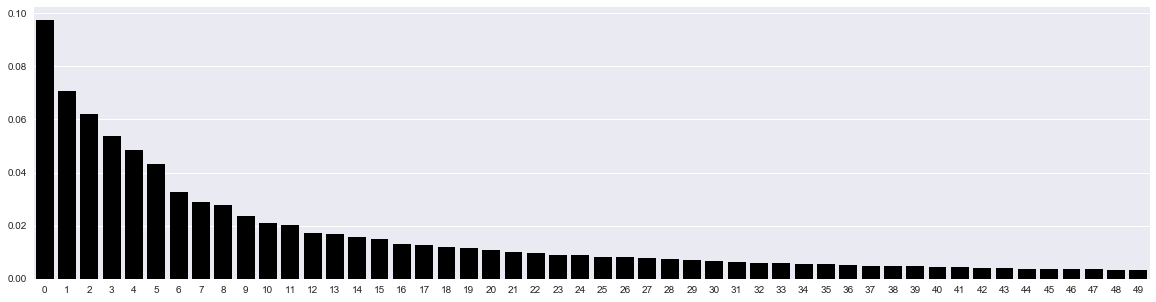

In [16]:
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:49],color='k')

In [4]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

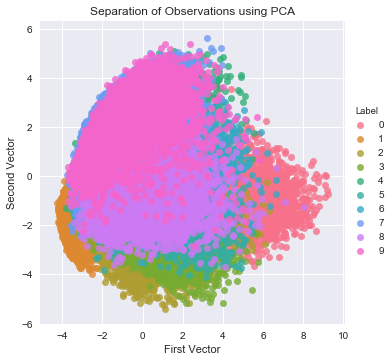

In [18]:
scatterPlot(X_train_PCA, y_train, "PCA")

Text(0.5,1,'Separation of Observations Using Original Feature Set')

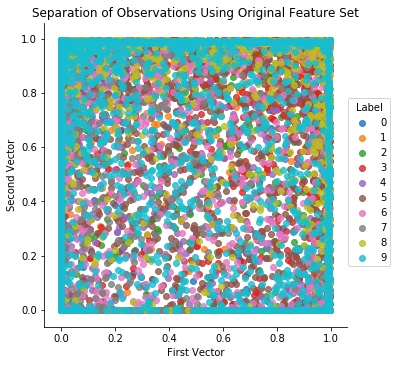

In [127]:
X_train_scatter = pd.DataFrame(data=X_train.loc[:,[350,406]], index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter,y_train), axis=1, join="inner")
X_train_scatter.columns = ["First Vector", "Second Vector", "Label"]
sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=X_train_scatter, fit_reg=False)
ax = plt.gca()
ax.set_title("Separation of Observations Using Original Feature Set")

In [68]:
from sklearn.cluster import KMeans

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,20),columns=['inertia'])
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state, n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

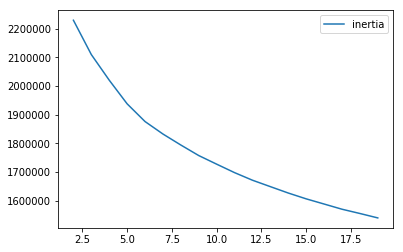

In [239]:
kMeans_inertia.plot()

In [1]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster,left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

In [242]:
from sklearn.cluster import KMeans

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,20),columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=range(2,20),columns=['overallAccuracy'])

for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state, n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

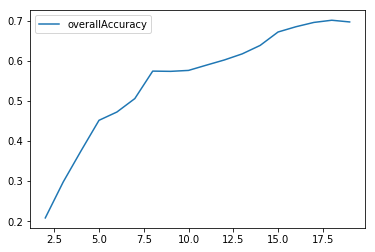

In [244]:
overallAccuracy_kMeansDF.plot()

In [245]:
accuracyByLabel_kMeans

0     0.637186
1     0.901295
2     0.849005
3     0.522881
4     0.708937
5     0.951272
6     0.953785
7     0.922039
8     0.389614
9     0.491312
10    0.383489
11    0.588647
12    0.464583
13    0.927543
14    0.849637
15    0.942870
16    0.797370
17    0.845355
18    0.457368
dtype: float64

In [24]:
from sklearn.cluster import KMeans

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784],columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784],columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state, n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

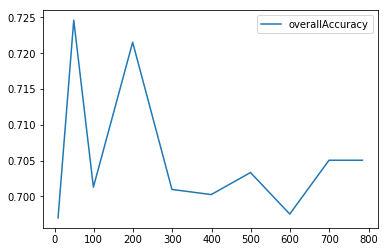

In [25]:
overallAccuracy_kMeansDF.plot()

In [26]:
from sklearn.cluster import KMeans

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784],columns=['inertia'])
overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, 99, 199, 299, 399, 499, 599, 699, 784],columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 784]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
                   tol=tol, random_state=random_state, n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

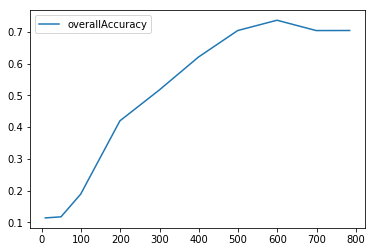

In [31]:
overallAccuracy_kMeansDF.plot()

In [92]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

cutoff = 100
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [109]:
cophenet_correlation_distance, cophenetic_distance_matrix = cophenet(Z[0:35000], pdist(X_train_PCA.iloc[0:35000,0:cutoff]))
cophenet_correlation_distance

ValueError: Linkage 'Z' uses non-singleton cluster before it is formed.

In [105]:
Z_dataFrame

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562682,2.0
1,28350.0,37674.0,0.590866,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627762,2.0
4,24707.0,43151.0,0.637668,2.0
5,20465.0,24483.0,0.662557,2.0
6,466.0,42098.0,0.664189,2.0
7,46542.0,49961.0,0.665520,2.0
8,2301.0,5732.0,0.671215,2.0
9,37564.0,47668.0,0.675121,2.0


In [108]:
Z_dataFrame.iloc[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99965.0,99972.0,161.106998,5197.0
49981,99932.0,99980.0,172.070003,6505.0
49982,99945.0,99960.0,182.840860,3245.0
49983,99964.0,99976.0,184.475761,3683.0
49984,99974.0,99979.0,185.027847,7744.0
49985,99940.0,99975.0,185.345207,5596.0
49986,99957.0,99967.0,211.854714,5957.0
49987,99938.0,99983.0,215.494857,4846.0
49988,99978.0,99984.0,216.760365,11072.0
49989,99970.0,99973.0,217.355871,4899.0


In [114]:
from scipy.cluster.hierarchy import fcluster
distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [124]:
print("Number of distinct clusters: ",len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [125]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = analyzeCluster(X_train_hierClustered, y_train)
print("Overall accuracy from hierarchical clustering: ",overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [132]:
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

In [305]:
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 100
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan = analyzeCluster(X_train_PCA_dbscanClustered, y_train)
overallAccuracy_dbscan

0.24154

In [307]:
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.24154


In [308]:
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39651
1,0,8832
2,8,711
3,5,90
4,18,45
5,36,35
6,37,22
7,52,19
8,4,16
9,20,16


In [312]:
import hdbscan

min_cluster_size = 10
min_samples = 10
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, cluster_selection_method=cluster_selection_method)

cutoff = 100
X_train_PCA_hdbscanClustered = hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_hdbscanClustered = pd.DataFrame(data=X_train_PCA_hdbscanClustered, index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, countMostFreq_hdbscan, accuracyDF_hdbscan, overallAccuracy_hdbscan, accuracyByLabel_hdbscan = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

In [317]:
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.26146


In [318]:
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,41956
1,18,5237
2,7,1079
3,13,631
4,19,385
5,3,311
6,16,93
7,10,46
8,5,41
9,12,38


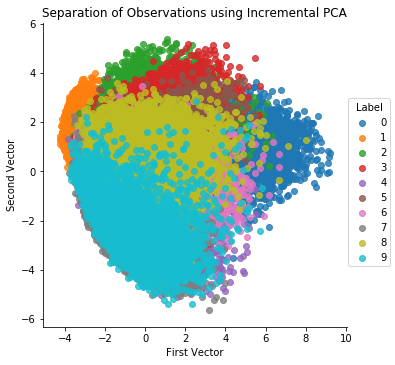

In [18]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components, batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

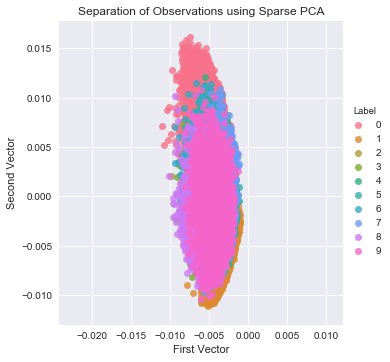

In [34]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

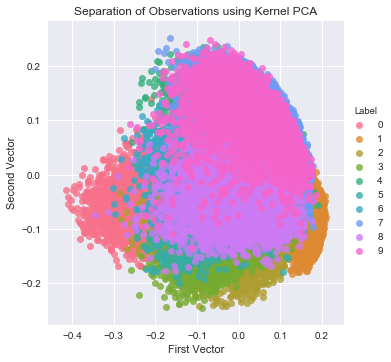

In [35]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

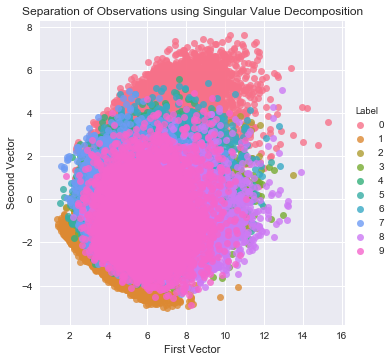

In [36]:
# Singular Value Decomposition

from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 2018

svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)

scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")

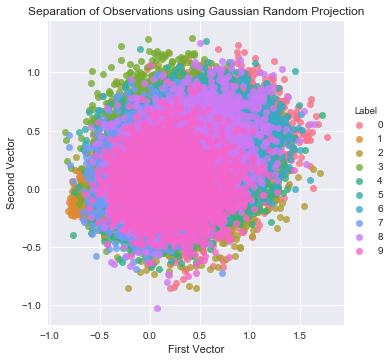

In [37]:
# Gaussian Random Projection

from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)

X_validation_GRP = GRP.transform(X_validation)
X_validation_GRP = pd.DataFrame(data=X_validation_GRP, index=validation_index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

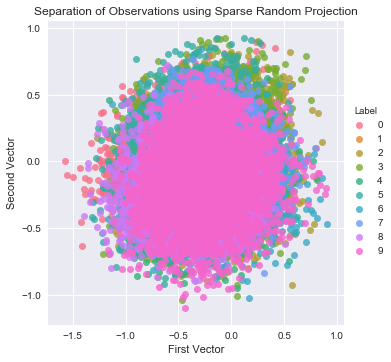

In [34]:
# Sparse Random Projection

from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, 
                             dense_output=dense_output, random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)

X_validation_SRP = SRP.transform(X_validation)
X_validation_SRP = pd.DataFrame(data=X_validation_SRP, index=validation_index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

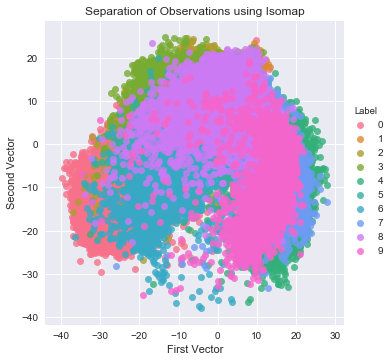

In [38]:
# Isomap

from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 10
n_jobs = 4

isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components, n_jobs=n_jobs)

isomap.fit(X_train.loc[0:5000,:])
X_train_isomap = isomap.transform(X_train)
X_train_isomap = pd.DataFrame(data=X_train_isomap, index=train_index)

X_validation_isomap = isomap.transform(X_validation)
X_validation_isomap = pd.DataFrame(data=X_validation_isomap, index=validation_index)

scatterPlot(X_train_isomap, y_train, "Isomap")

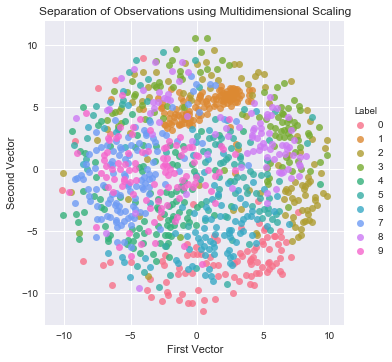

In [39]:
# Multidimensional Scaling

from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, metric=metric,
          n_jobs=n_jobs, random_state=random_state)

X_train_mds = mds.fit_transform(X_train.loc[0:1000,:])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])

scatterPlot(X_train_mds, y_train, "Multidimensional Scaling")

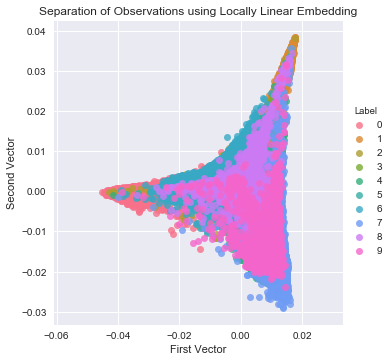

In [40]:
# Locally Linear Embedding (LLE)

from sklearn.manifold import LocallyLinearEmbedding

n_neighbors = 10
n_components = 2
method = 'modified'
n_jobs = 4
random_state = 2018

lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method=method,
                             random_state=random_state, n_jobs=n_jobs)

lle.fit(X_train.loc[0:5000,:])
X_train_lle = lle.transform(X_train)
X_train_lle = pd.DataFrame(data=X_train_lle, index=train_index)

X_validation_lle = lle.transform(X_validation)
X_validation_lle = pd.DataFrame(data=X_validation_lle, index=validation_index)

scatterPlot(X_train_lle, y_train, "Locally Linear Embedding")

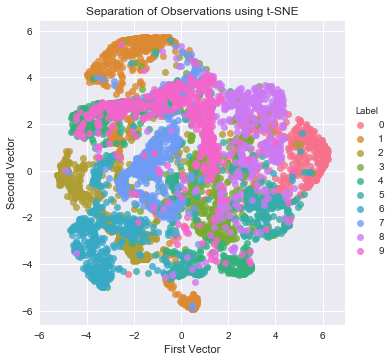

In [41]:
# t-SNE

from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30 # t-SNE is not very sensitive to this hyperparameter
early_exaggeration = 12 # t-SNE is not very sensitive to this hyperparameter
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, perplexity=perplexity,
            early_exaggeration=early_exaggeration, init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatterPlot(X_train_tSNE, y_train, "t-SNE")

C:\Program Files\Anaconda3\envs\projectSample\lib\site-packages\sklearn\decomposition\dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


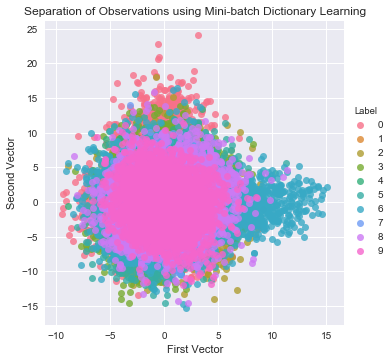

In [42]:
# Mini-batch dictionary learning

from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 50
alpha = 1
batch_size = 200
n_iter = 25
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size,
                                                    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train.loc[:,:10000])
X_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = pd.DataFrame(data=X_train_miniBatchDictLearning, index=train_index)

X_validation_miniBatchDictLearning = miniBatchDictLearning.transform(X_validation)
X_validation_miniBatchDictLearning = pd.DataFrame(data=X_validation_miniBatchDictLearning, index=validation_index)

scatterPlot(X_train_miniBatchDictLearning, y_train, "Mini-batch Dictionary Learning")

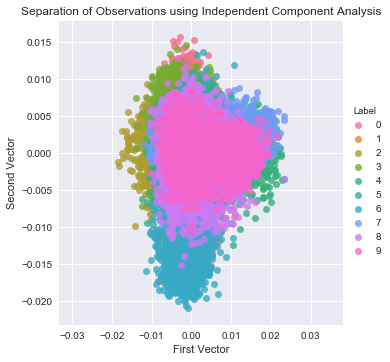

In [43]:
# Independent Component Analysis

from sklearn.decomposition import FastICA

n_components = 25
algorithm = 'parallel'
whiten = True
max_iter = 100
random_state = 2018

fastICA = FastICA(n_components=n_components, algorithm=algorithm, whiten=whiten, max_iter=max_iter, random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=train_index)

X_validation_fastICA = fastICA.transform(X_validation)
X_validation_fastICA = pd.DataFrame(data=X_validation_fastICA, index=validation_index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

In [5]:
# Anomaly detection

data = pd.read_csv('creditcard.csv')

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX.loc[:,featuresToScale])

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)

In [6]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [7]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
              areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

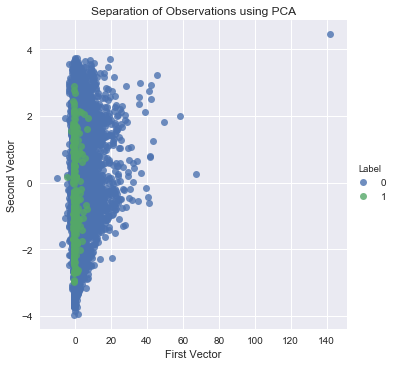

In [9]:
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

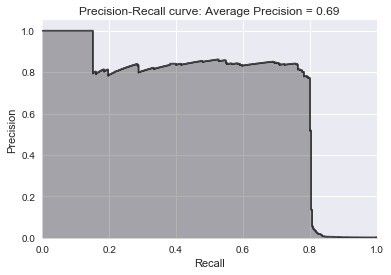

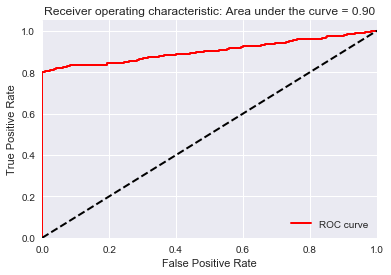

In [10]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [11]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop.anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.75
Recall:  0.8


In [101]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
preds

,trueLabel,anomalyScore
154684,1,1.000000e+00
154234,1,9.400473e-01
151006,1,9.344947e-01
151009,1,9.344947e-01
151008,1,9.344947e-01
151007,1,9.344947e-01
151462,1,8.991906e-01
152295,1,8.960359e-01
152223,1,8.938202e-01
150925,1,8.730133e-01


In [13]:
def analyzeCluster(clusterDF, labelsDF, precisionThreshold):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countFraud = pd.DataFrame(data=preds[preds.trueLabel==1].groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    countFraud.reset_index(inplace=True,drop=False)
    countFraud.columns = ['cluster','countFraud']
    
    precisionDF = countFraud.merge(countByCluster,left_on="cluster",right_on="cluster")
    precisionDF['precision'] = precisionDF.countFraud/precisionDF.clusterCount
    precisionDF = precisionDF[precisionDF.precision>precisionThreshold]
    
    if precisionDF.empty:
        precision = 0
    else:
        precision = precisionDF.countFraud.sum()/precisionDF.clusterCount.sum()
    
    recall = precisionDF.countFraud.sum()/preds.trueLabel.sum()
    precisionByCluster = precisionDF.precision
    return countByCluster, countByLabel, countFraud, precisionDF, precision, recall, precisionByCluster

In [102]:
from sklearn.decomposition import PCA

n_components = 30
whiten = True
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA = X_train_PCA.merge(preds,left_index=True,right_index=True)
X_train_PCA.drop('trueLabel',axis=1,inplace=True)
#X_train_PCA

#scatterPlot(X_train_PCA, y_train, "PCA")

featuresToScale = X_train_PCA.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_PCA.loc[:,:] = sX.fit_transform(X_train_PCA.loc[:,:])

In [108]:
from sklearn.cluster import KMeans

n_clusters = 3
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(X_train_PCA)
X_train_PCA_kmeansClustered = kmeans.predict(X_train_PCA)
X_train_PCA_kmeansClustered = pd.DataFrame(data=X_train_PCA_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])

precisionThreshold = 0.50
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
print("Precision: ", precision_kMeans)
print("Recall: ", recall_kMeans)

Precision:  0
Recall:  0.0


In [109]:
precisionDF_kMeans

,cluster,countFraud,clusterCount,precision


In [110]:
precisionThreshold = 0.00
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
precisionDF_kMeans

,cluster,countFraud,clusterCount,precision
0,0,155,13782,0.011247
1,1,109,91689,0.001189
2,2,66,85349,0.000773


In [ ]:
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 50000
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.iloc[:cutoff])
X_train_PCA_dbscanClustered = pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.iloc[:cutoff].index, columns=['cluster'])

precisionThreshold = 0.50
countByCluster_dbscan, countByLabel_dbscan, countFraud_dbscan, precisionDF_dbscan, precision_dbscan, recall_dbscan, precisionByCluster_dbscan = analyzeCluster(X_train_PCA_dbscanClustered, y_train, precisionThreshold)
print("Precision: ", precision_dbscan)
print("Recall: ", recall_dbscan)

In [57]:
import hdbscan

min_cluster_size = 50
min_samples = 50
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, alpha=alpha, cluster_selection_method=cluster_selection_method)

cutoff = 50000
X_train_PCA_hdbscanClustered = hdb.fit_predict(X_train_PCA.iloc[:cutoff])
X_train_PCA_hdbscanClustered = pd.DataFrame(data=X_train_PCA_hdbscanClustered, index=X_train.iloc[:cutoff].index, columns=['cluster'])

precisionThreshold = 0.0
countByCluster_hdbscan, countByLabel_hdbscan, countFraud_hdbscan, precisionDF_hdbscan, precision_hdbscan, recall_hdbscan, precisionByCluster_hdbscan = analyzeCluster(X_train_PCA_hdbscanClustered, y_train, precisionThreshold)
print("Precision: ", precision_hdbscan)
print("Recall: ", recall_hdbscan)

Precision:  0.0021469289045727116
Recall:  0.2636363636363636


In [61]:
countByCluster_hdbscan

,cluster,clusterCount
0,-1,40523
1,41,477
2,26,451
3,43,444
4,36,409
5,7,402
6,44,392
7,35,382
8,8,301
9,12,294


In [62]:
countByLabel_hdbscan

,cluster
trueLabel,
0,49913
1,87


In [60]:
precisionDF_hdbscan

,cluster,countFraud,clusterCount,precision
0,-1,87,40523,0.002147


In [32]:
accuracyDF_kMeans

,cluster,countMostFrequent,clusterCount
0,0,11532,11532
1,1,2586,2592
2,2,9318,9326
3,3,58380,58446
4,4,132,156
5,5,23526,23573
6,6,25520,25524
7,7,59604,59671


In [74]:
X_train_PCA_kmeansClustered['Cluster'].value_counts()

2    71995
3    70667
1    28101
6    15114
0     2935
7      978
5      970
4       60
Name: Cluster, dtype: int64

In [75]:
preds = pd.concat([y_train, X_train_PCA_kmeansClustered], axis=1)
preds.columns = ['trueLabel', 'cluster']

In [76]:
preds[preds.trueLabel==1].groupby('cluster').count()/preds.groupby('cluster').count()

,trueLabel
cluster,
0,0.002726
1,0.002100
2,0.000903
3,0.001769
4,NaN
5,0.012371
6,0.003242
7,0.012270


In [77]:
preds[preds.trueLabel==1]['cluster'].value_counts()

3    125
2     65
1     59
6     49
7     12
5     12
0      8
Name: cluster, dtype: int64

In [ ]:
from sklearn.cluster import DBSCAN

eps = 0.9
min_samples = 50
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

X_train_PCA_dbClustered = db.fit_predict(X_train_PCA)
X_train_PCA_dbClustered = pd.DataFrame(data=X_train_PCA_dbClustered, index=X_train.index, columns=['Cluster'])


In [ ]:
X_train_PCA_dbClustered['Cluster'].value_counts()

In [ ]:
preds = pd.concat([y_train, X_train_PCA_dbClustered], axis=1)
preds.columns = ['trueLabel', 'cluster']

In [ ]:
preds[preds.trueLabel==1].groupby('cluster').count()/preds.groupby('cluster').count()

In [97]:
preds[preds.trueLabel==1]['cluster'].value_counts()

-1    326
 1      3
 0      1
Name: cluster, dtype: int64

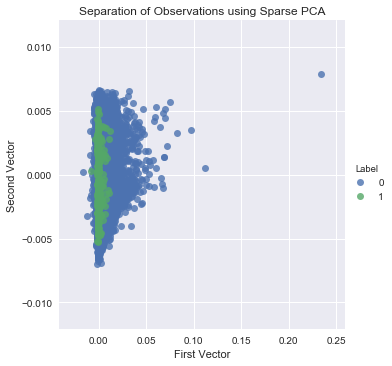

In [111]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

In [112]:
X_train_sparsePCA.shape

(190820, 27)

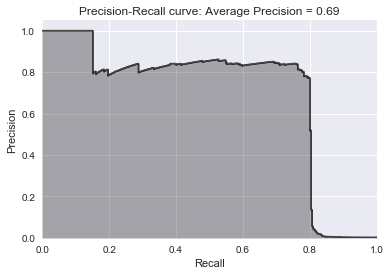

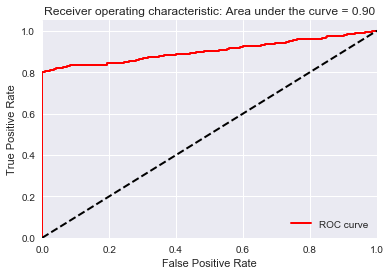

In [113]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA).dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

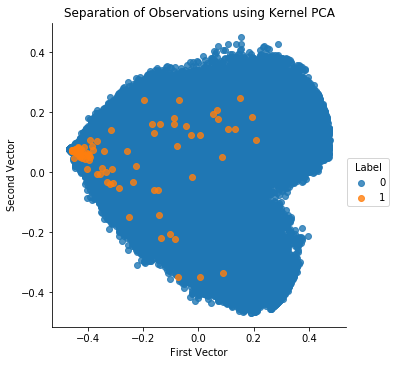

In [27]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, 
                      fit_inverse_transform=fit_inverse_transform, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse,index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

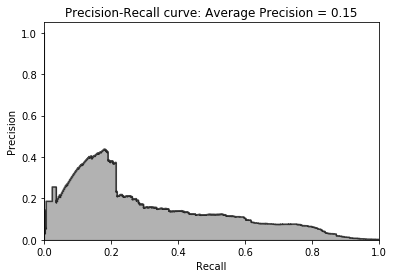

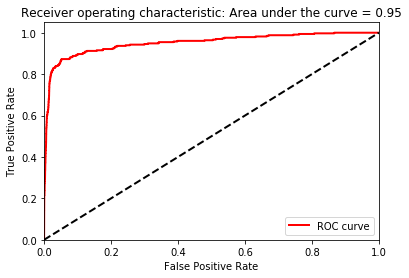

In [28]:
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

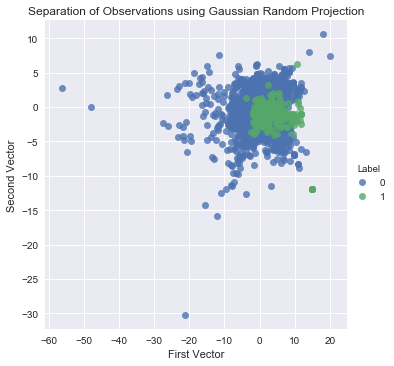

In [137]:
# Gaussian Random Projection

from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

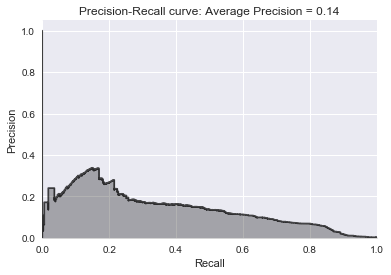

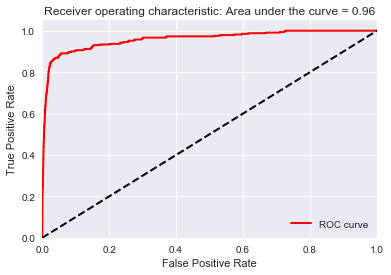

In [138]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, index=X_train.index)

anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

In [139]:
from sklearn.cluster import KMeans

n_clusters = 8
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(X_train_GRP)
X_train_PCA_kmeansClustered = kmeans.predict(X_train_GRP)
X_train_PCA_kmeansClustered = pd.DataFrame(data=X_train_PCA_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])

precisionThreshold = 0.50
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
print("Precision: ", precision_kMeans)
print("Recall: ", recall_kMeans)

Precision:  0.7289719626168224
Recall:  0.4727272727272727


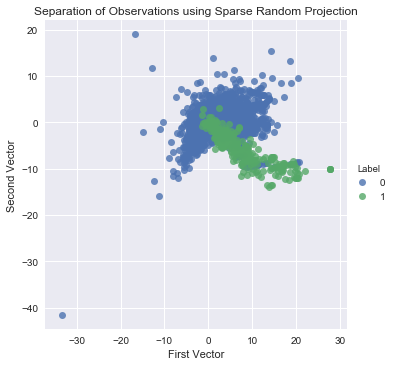

In [140]:
# Sparse Random Projection

from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, 
                             dense_output=dense_output, random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

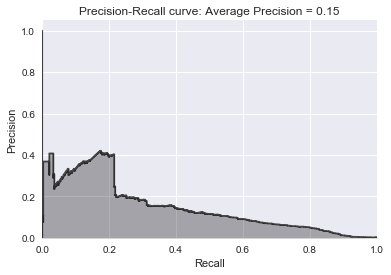

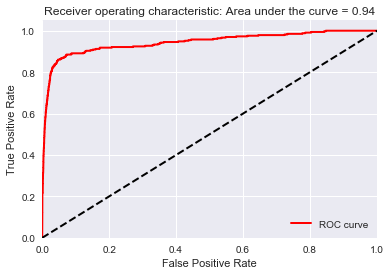

In [141]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

In [142]:
from sklearn.cluster import KMeans

n_clusters = 8
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(X_train_SRP)
X_train_PCA_kmeansClustered = kmeans.predict(X_train_SRP)
X_train_PCA_kmeansClustered = pd.DataFrame(data=X_train_PCA_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])

precisionThreshold = 0.50
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
print("Precision: ", precision_kMeans)
print("Recall: ", recall_kMeans)

Precision:  0
Recall:  0.0


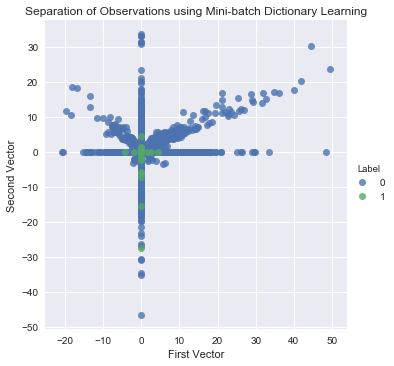

In [152]:
# Mini-batch dictionary learning

from sklearn.decomposition import MiniBatchDictionaryLearning

# 28 components, 1 alpha, 200 batch size, 10 n_iter generates average precision of 0.42
n_components = 40
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size,
                                                    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, "Mini-batch Dictionary Learning")

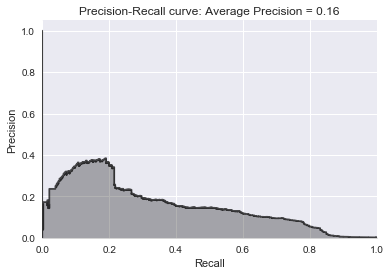

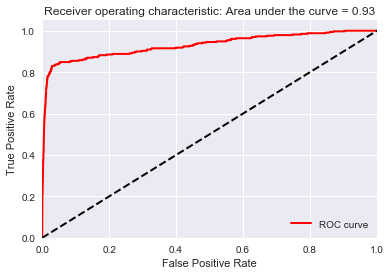

In [153]:
X_train_miniBatchDictLearning_inverse = np.array(X_train_miniBatchDictLearning).dot(miniBatchDictLearning.components_)
X_train_miniBatchDictLearning_inverse = pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

In [154]:
from sklearn.cluster import KMeans

n_clusters = 8
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(X_train_miniBatchDictLearning)
X_train_PCA_kmeansClustered = kmeans.predict(X_train_miniBatchDictLearning)
X_train_PCA_kmeansClustered = pd.DataFrame(data=X_train_PCA_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])

precisionThreshold = 0.50
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
print("Precision: ", precision_kMeans)
print("Recall: ", recall_kMeans)

Precision:  0
Recall:  0.0


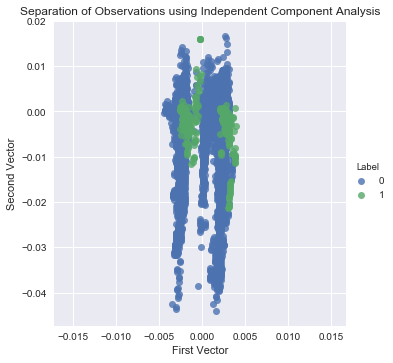

In [148]:
# Independent Component Analysis

from sklearn.decomposition import FastICA

# 27 components generates average precision of 0.69
n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, algorithm=algorithm, whiten=whiten, max_iter=max_iter, random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

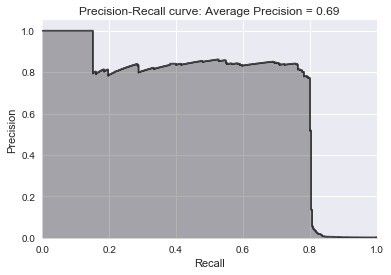

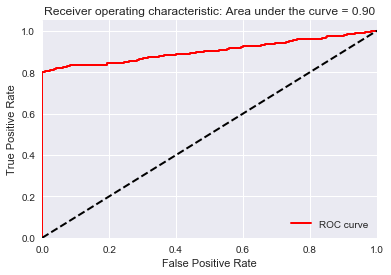

In [149]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
plotResults(y_train, anomalyScoresFastICA)

In [151]:
from sklearn.cluster import KMeans

n_clusters = 8
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(X_train_fastICA)
X_train_PCA_kmeansClustered = kmeans.predict(X_train_fastICA)
X_train_PCA_kmeansClustered = pd.DataFrame(data=X_train_PCA_kmeansClustered, index=X_train.index, 
                                           columns=['cluster'])

precisionThreshold = 0.50
countByCluster_kMeans, countByLabel_kMeans, countFraud_kMeans, precisionDF_kMeans, precision_kMeans, recall_kMeans, precisionByCluster_kMeans = analyzeCluster(X_train_PCA_kmeansClustered, y_train, precisionThreshold)
print("Precision: ", precision_kMeans)
print("Recall: ", recall_kMeans)

Precision:  0
Recall:  0.0


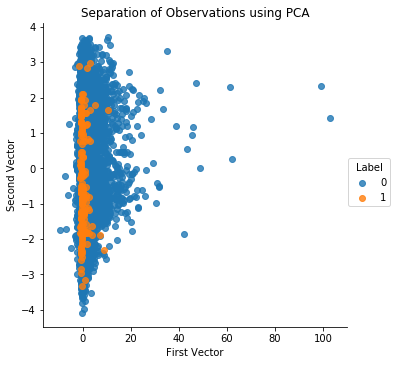

In [103]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

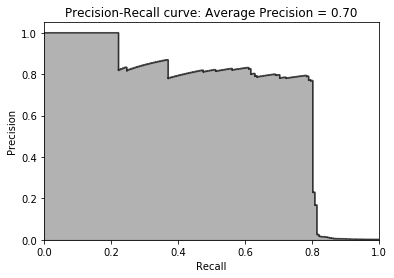

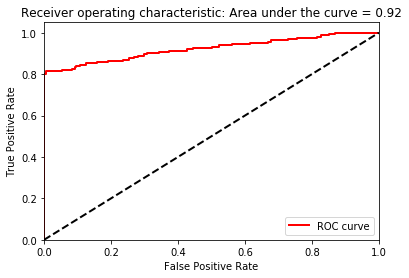

In [104]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

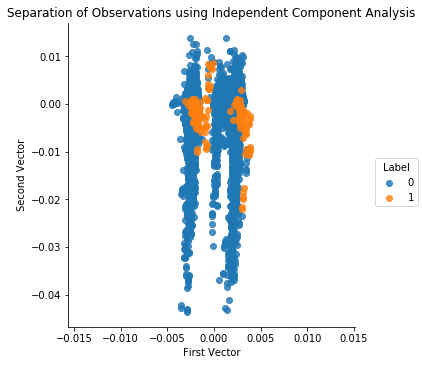

In [105]:
# Independent Component Analysis on Test Set
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse, index=X_test.index)

scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

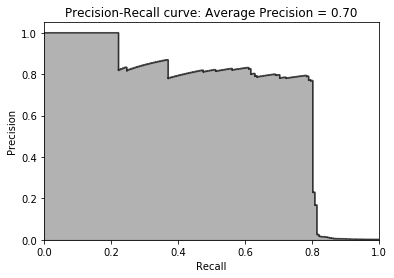

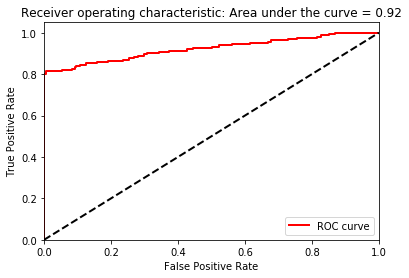

In [106]:
anomalyScoresFastICA = anomalyScores(X_test, X_test_fastICA_inverse)
plotResults(y_test, anomalyScoresFastICA)

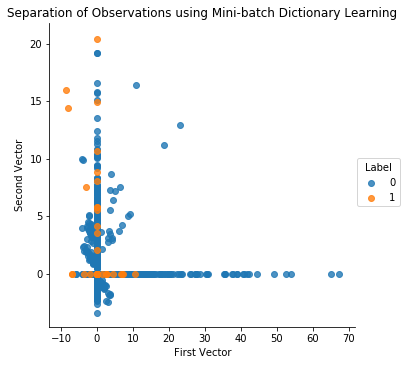

In [107]:
X_test_miniBatchDictLearning = miniBatchDictLearning.transform(X_test)
X_test_miniBatchDictLearning = pd.DataFrame(data=X_test_miniBatchDictLearning, index=X_test.index)

scatterPlot(X_test_miniBatchDictLearning, y_test, "Mini-batch Dictionary Learning")

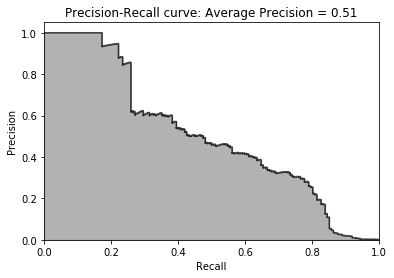

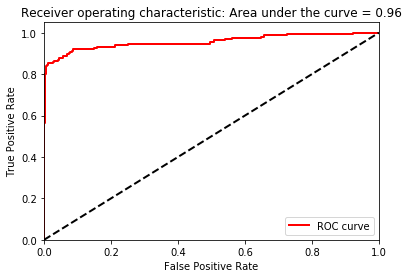

In [108]:
X_test_miniBatchDictLearning_inverse = np.array(X_test_miniBatchDictLearning).dot(miniBatchDictLearning.components_)
X_test_miniBatchDictLearning_inverse = pd.DataFrame(data=X_test_miniBatchDictLearning_inverse, index=X_test.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_test, X_test_miniBatchDictLearning_inverse)
preds = plotResults(y_test, anomalyScoresMiniBatchDictLearning, True)

In [96]:
def mergeDFs(df1, df2):
    df2 = pd.DataFrame(data=df2,index=df2.index)
    df1 = df1.merge(df2,left_index=True,right_index=True)
    return df1

In [97]:
anomalyScoresDF = pd.DataFrame(data=[],index=X_train.index)
anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresPCA)
#anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresSparsePCA)
#anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresKernelPCA)
#anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresGRP)
#anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresSRP)
#anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresMiniBatchDictLearning)
anomalyScoresDF = mergeDFs(anomalyScoresDF,anomalyScoresFastICA)

In [99]:
anomalyScoresDF.columns = ['PCA','Fast ICA']
#anomalyScoresDF.columns = ['PCA','Sparse PCA','Kernel PCA','GRP','SRP','Mini Batch Dict Learning','Fast ICA']

In [100]:
anomalyScoresDF.describe()

,PCA,Fast ICA
count,190820.000000,190820.000000
mean,0.000643,0.000643
std,0.016074,0.016074
min,0.000000,0.000000
25%,0.000021,0.000021
50%,0.000067,0.000067
75%,0.000193,0.000193
max,1.000000,1.000000


In [33]:
featuresToScale = anomalyScoresDF.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
anomalyScoresDF.loc[:,featuresToScale] = sX.fit_transform(anomalyScoresDF.loc[:,featuresToScale])

In [101]:
anomalyScoresAverages = anomalyScoresDF.mean(axis=1)
anomalyScoresAverages

142087    0.000211
165168    0.000031
235908    0.000205
148255    0.000144
145672    0.000472
277038    0.000313
228711    0.000227
135075    0.000058
21964     0.000146
54269     0.000022
197783    0.000005
246802    0.000015
59330     0.000068
94970     0.000044
159748    0.000016
140395    0.000148
46151     0.000026
224220    0.000244
9951      0.000006
40386     0.000073
17709     0.000046
16474     0.000008
98563     0.000047
95570     0.000190
65038     0.000017
157292    0.000058
256039    0.000026
140317    0.000100
25338     0.000209
66863     0.000033
            ...   
282090    0.000307
282618    0.000182
260841    0.000423
217636    0.000083
210463    0.000014
171260    0.000150
3069      0.000004
8161      0.000018
149066    0.000172
157742    0.000154
195347    0.000540
82379     0.000182
16249     0.000091
148702    0.000014
85268     0.000081
240094    0.000001
262779    0.000042
132800    0.000054
40121     0.000851
17485     0.000024
186563    0.000006
254976    0.

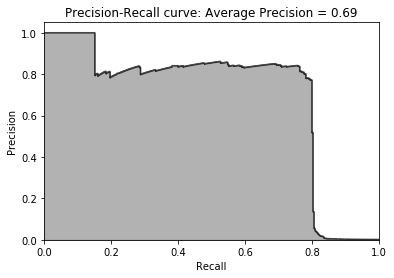

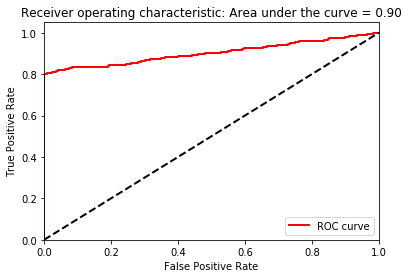

In [102]:
plotResults(y_train, anomalyScoresAverages)

In [416]:
from sklearn.cluster import KMeans

n_clusters = 35
n_init = 10
max_iter = 300
tol = 0.0004
random_state = 2018
n_jobs = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,
               tol=tol, random_state=random_state, n_jobs=n_jobs)

kmeans.fit(anomalyScoresDF)
anomalyScoresDF_kmeansClustered = kmeans.predict(anomalyScoresDF)
anomalyScoresDF_kmeansClustered = pd.DataFrame(data=anomalyScoresDF_kmeansClustered, index=X_train.index, 
                                           columns=['Cluster'])

In [33]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 15
leaf_size = 30
n_jobs = 2

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs, algorithm='kd_tree')

anomalyScoresDF_dbClustered = hdb.fit_predict(anomalyScoresDF)
anomalyScoresDF_dbClustered = pd.DataFrame(data=anomalyScoresDF_dbClustered, index=X_train.index, columns=['Cluster'])


In [241]:
import hdbscan

min_cluster_size = 5
min_samples = 1

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)

anomalyScoresDF_hdbClustered = hdb.fit_predict(anomalyScoresDF)
anomalyScoresDF_hdbClustered = pd.DataFrame(data=anomalyScoresDF_hdbClustered, index=X_train.index, columns=['Cluster'])


In [242]:
anomalyScoresDF_hdbClustered['Cluster'].value_counts()

-1        31073
 14393       70
 15725       55
 5033        55
 14674       54
 13979       53
 10831       52
 11348       51
 3698        50
 14622       48
 3985        48
 4535        47
 11117       46
 15055       46
 5600        45
 180         45
 8379        45
 6784        45
 16483       45
 12136       44
 2869        44
 11690       44
 15534       43
 13260       43
 3973        43
 1631        42
 14048       42
 3108        40
 13520       39
 1832        39
          ...  
 4888         5
 14144        5
 4676         5
 5352         5
 11375        5
 9326         5
 7833         5
 15297        5
 5060         5
 15773        5
 13724        5
 3015         5
 11331        5
 13596        5
 3355         5
 1094         5
 120          5
 2169         5
 1178         5
 11295        5
 1350         5
 9666         5
 2923         5
 15261        5
 4968         5
 13036        5
 3655         5
 7877         5
 2843         5
 12471        5
Name: Cluster, Length: 1

In [243]:
#anomalyScoresDF_kmeansClustered['Cluster'].value_counts()

In [244]:
preds = pd.concat([y_train, anomalyScoresDF_hdbClustered], axis=1)
preds.columns = ['trueLabel', 'cluster']

In [245]:
freqDF = preds[preds.trueLabel==1].groupby('cluster').count()/preds.groupby('cluster').count()
freqDF.reset_index(inplace=True)
freqDF.columns = ['cluster','frequency']
freqDF.sort_values(by='frequency',ascending=False,inplace=True)
freqDF

,cluster,frequency
2,1,1.000000
3,2,1.000000
4,3,1.000000
5,4,1.000000
6,5,1.000000
31,30,1.000000
9,8,1.000000
10,9,1.000000
11,10,1.000000
13,12,1.000000


In [246]:
countDF = preds[preds.trueLabel==1].groupby('cluster').count()
countDF.reset_index(inplace=True)
countDF.columns = ['cluster','trueCount']
countDF.sort_values(by='trueCount',ascending=False,inplace=True)
countDF

,cluster,trueCount
0,-1,36
15,15,31
11,10,23
18,22,21
13,12,16
1,0,15
22,30,15
2,1,13
9,8,11
19,25,11


In [247]:
clusterSizeDF = preds.groupby('cluster').count()
clusterSizeDF.reset_index(inplace=True)
clusterSizeDF.columns = ['cluster','clusterSize']
clusterSizeDF

,cluster,clusterSize
0,-1,31073
1,0,33
2,1,13
3,2,9
4,3,5
5,4,6
6,5,6
7,6,10
8,7,9
9,8,11


In [248]:
predsX2 = preds.merge(freqDF,left_on='cluster',right_on='cluster').merge(
    countDF,left_on='cluster',right_on='cluster').merge(clusterSizeDF,left_on='cluster',right_on='cluster')
#predsX2

In [249]:
preds[preds.trueLabel==1]['cluster'].value_counts()

-1        36
 15       31
 10       23
 22       21
 12       16
 0        15
 30       15
 1        13
 25       11
 8        11
 29        9
 6         9
 2         9
 26        7
 14        7
 21        6
 5         6
 4         6
 11        6
 20        5
 9         5
 3         5
 7         4
 8720      1
 10831     1
 113       1
 111       1
 8294      1
 604       1
 83        1
          ..
 42        1
 12303     1
 4230      1
 3985      1
 12708     1
 15269     1
 2990      1
 11706     1
 6588      1
 7108      1
 15150     1
 11802     1
 10020     1
 1817      1
 16008     1
 3749      1
 12968     1
 11954     1
 180       1
 697       1
 192       1
 4293      1
 9420      1
 7373      1
 8933      1
 5350      1
 13561     1
 6677      1
 1300      1
 5765      1
Name: cluster, Length: 77, dtype: int64

In [262]:
threshold = 0.19
predsX2['trueLabel'][predsX2.frequency>threshold].sum()/predsX2[predsX2.frequency>threshold].count()

trueLabel      0.76161
cluster        0.76161
frequency      0.76161
trueCount      0.76161
clusterSize    0.76161
dtype: float64

In [263]:
predsX2[predsX2.frequency>threshold]['trueLabel'].sum()/330

0.7454545454545455